# Running AOS Close Loop with AuxTel images

## Load Data

#### AuxTel data 
structured array with intra/extra images, as well as a mask produced by the CWFS package. Also there is a pandas dataframe with a bunch of meta-data for each doughnut, imageIDs, hexapod position etc

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
ajc_donut_dir = '/epyc/users/ajc26/LSST-Commissioning/aoc/donut_analysis'
data  = np.load(os.path.join(ajc_donut_dir, "with_zerns/20200123_CWFS_verification_bin_1_sens_161_cross_terms_True_cam_rot_0.npy"))

#### Metadata

In [2]:
metadata = pd.read_csv(os.path.join(ajc_donut_dir, "with_zerns/20200123_CWFS_verification_bin_1_sens_161_cross_terms_True_cam_rot_0.csv"))

In [3]:
metadata

,Unnamed: 0,intraID,extraID,nas_pos,el_pos,cam_to_bore_ang,hex_x,hex_y,meas_comaX,meas_comaY,meas_defocus,derot_comaX,derot_comaY,derot_defocus,hex_dx,hex_dy,hex_dz,dAz,dEl,drot
0,0,2020031600092,2020031600093,67.371253,67.870881,-0.499627,-5.215930,1.761277,11.713700,139.014027,61.153736,10.501048,139.110886,61.153736,0.065224,-0.864043,0.007452,3.913434,-51.842566,0.0
1,1,2020031600094,2020031600095,7.226426,67.704268,-60.477842,-5.216106,1.761823,131.391395,38.974108,49.655280,30.830527,133.537104,49.655280,0.191494,-0.829423,0.009308,11.489637,-49.765381,0.0
2,2,2020031600096,2020031600097,-52.928532,67.488925,-120.417456,-5.216334,1.762527,123.920881,-87.586705,55.395736,12.790512,151.209188,55.395736,0.079444,-0.939188,0.010737,4.766651,-56.351250,0.0
3,3,2020031600098,2020031600099,-113.094192,67.344658,-180.438850,-5.216491,1.763020,-16.619629,-128.625952,79.872916,15.633958,128.749474,79.872916,0.097105,-0.799686,0.001356,5.826320,-47.981170,0.0
4,4,2020031600100,2020031600101,-173.181581,67.171286,-240.352867,-5.216669,1.763595,-125.266057,-50.575314,66.022585,18.009314,133.884697,66.022585,0.111859,-0.831582,0.005466,6.711546,-49.894918,0.0
5,5,2020031600102,2020031600103,111.367385,66.629021,44.738363,-5.217222,1.765401,-111.121600,115.316646,70.353626,2.235160,160.127895,70.353626,0.013883,-0.994583,0.008587,0.832979,-59.674992,0.0


Data Columns:

In [4]:
data.dtype

dtype([('intra_image', '<f8', (224, 224)), ('extra_image', '<f8', (224, 224)), ('image_mask', '<f8', (224, 224)), ('zern_index', '<i2', (19,)), ('measured_zerns', '<f8', (19,))])

#### Plot data

6 donuts in total

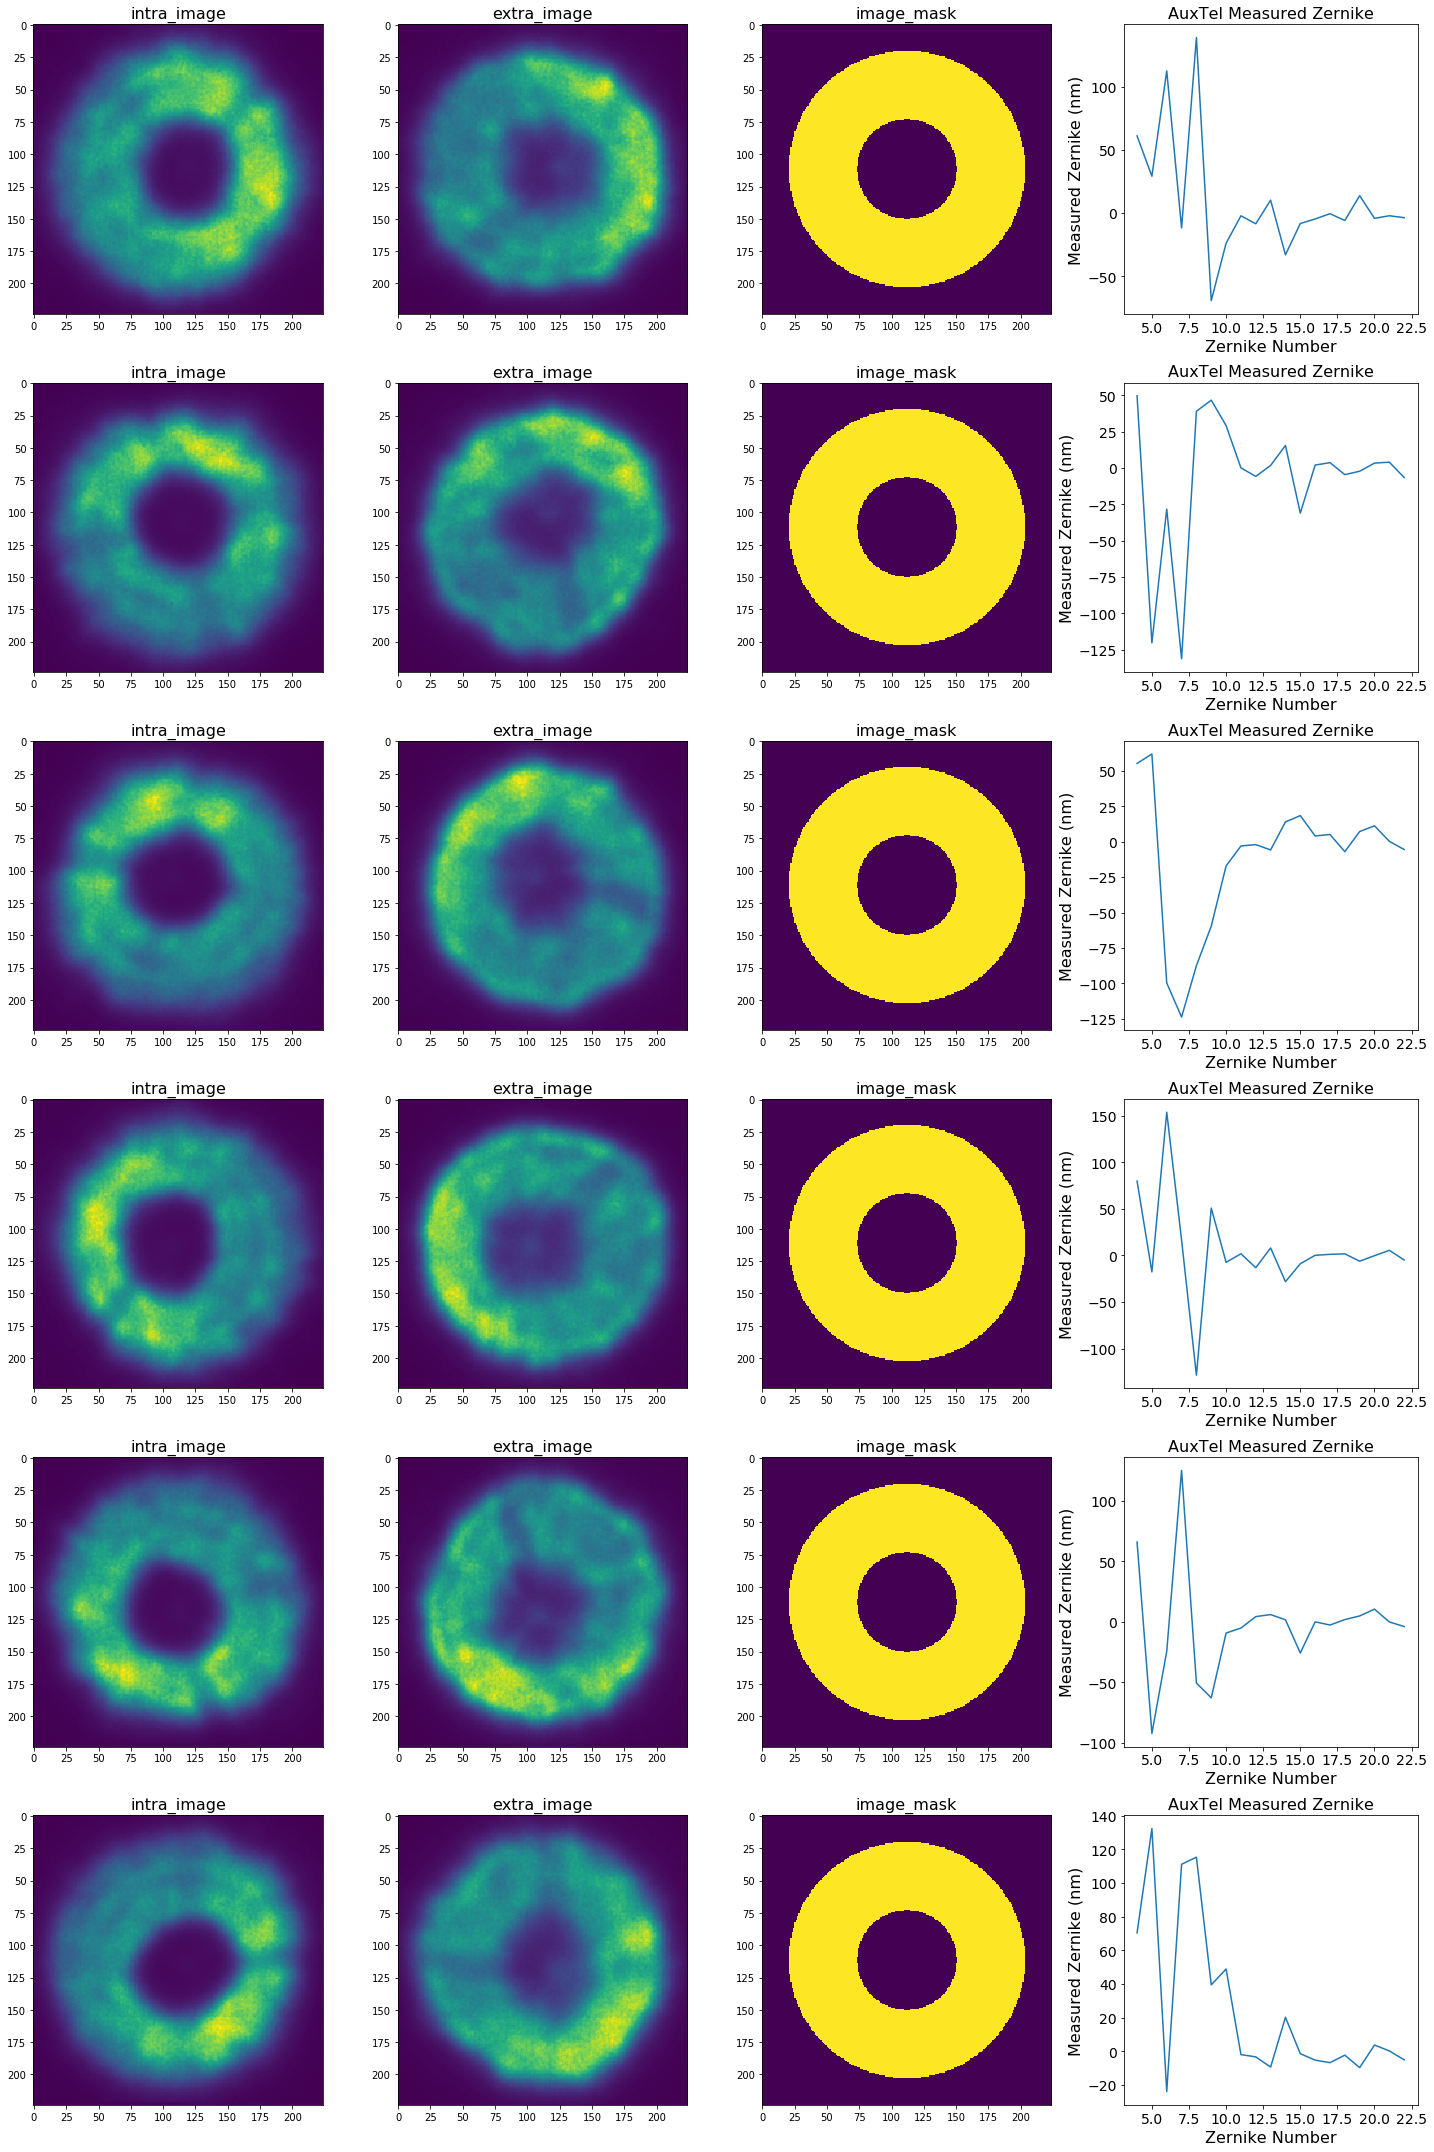

In [5]:
donut=0
fig = plt.figure(figsize=(20,30))
i = 1
for j in range(6):
    for col in ['intra_image', 'extra_image', 'image_mask', 'measured_zerns']:
        sub = fig.add_subplot(6,4, i )
        if i % 4 != 0:
            plt.imshow(data[col][j])
            plt.title(col, size=16)
        else:
            plt.plot(data['zern_index'][j], data[col][j])
            plt.xlabel('Zernike Number', size=16)
            plt.ylabel('Measured Zernike (nm)', size=16)
            plt.title('AuxTel Measured Zernike', size=16)
            plt.xticks(size=14)
            plt.yticks(size=14)
        i+=1
plt.tight_layout()

## Set up AuxTel to run on `ts_wep` code

Settings are from `instParam.yaml` file in `ts_wep/cwfs/instData/auxtel` that had the following:

```
---

# Auxiliary telescope parameters:

# Obscuration (inner_radius / outer_radius of primary mirror)
obscuration: 0.3525

# Focal length in m
focalLength: 21.6

# Aperture diameter in m
apertureDiameter: 1.2

# Move the M2 to fake the move of focal plane dz
# Move the M2 by 0.8 mm = move the focal plane by 0.0205 m
# Defocal distance offset in m
offset:
  0.8mm: 2.05e-2

# Camera pixel size in m
pixelSize: 14.4e-6
```

We also use the `AuxTel` camType.

In [6]:
from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.Utility import getConfigDir, getCentroidFindType, CamType, DefocalType, CentroidFindType
from lsst.ts.wep.ParamReader import ParamReader
from lsst.ts.wep.cwfs.Algorithm import Algorithm
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.cwfs.Instrument import Instrument

%load_ext autoreload
%autoreload 2

In [7]:
# Set up the configurations for the WfEstimator

configDir = getConfigDir()
instDir = os.path.join(configDir, "cwfs", "instData")
algoDir = os.path.join(configDir, "cwfs", "algo")

# Use new estimator to add defocal distance as we go
wfsEsti = WfEstimator(instDir, algoDir)

settingFileName = 'default.yaml'
settingFilePath = os.path.join(configDir, settingFileName)
settingFile = ParamReader(filePath=settingFilePath)

solver = settingFile.getSetting("poissonSolver")
# Using paraxial to follow Bo's notebook at bxin/cwfs/examples/AuxTel.ipynb. Is this right for these examples?
opticalModel = 'paraxial' 
defocalDistInMm = 0.8 # To match our instParam.yaml file
# Change to AuxTel data donut stamp size
donutImgSizeInPixel = np.shape(data['intra_image'][0])[0]

centroidFind = settingFile.getSetting("centroidFindAlgo")
centroidFindType = getCentroidFindType(centroidFind)

# New CamType
auxTel = CamType(4)

### Test on First Donut

In [8]:
# Configure the WfEstimator

wfsEsti.config(solver=solver, camType=auxTel,
               opticalModel=opticalModel,
               defocalDisInMm=defocalDistInMm,
               sizeInPix=donutImgSizeInPixel,
               centroidFindType=centroidFindType)

In [9]:
# Set Intra image
wfsEsti.setImg([0, 0], DefocalType(1), image=data['intra_image'][0])
# Set Extra image
wfsEsti.setImg([0, 0], DefocalType(2), image=data['extra_image'][0])

In [10]:
# Run the algorithm
wfsEsti.algo.runIt(wfsEsti.imgIntra, wfsEsti.imgExtra, wfsEsti.opticalModel)

In [11]:
# Get the Zernike estimates in nm
wfsEsti_zern = wfsEsti.algo.getZer4UpInNm()

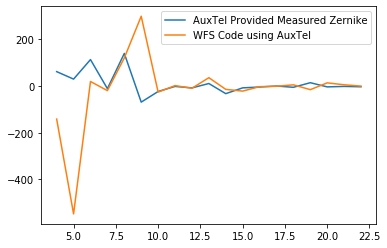

In [12]:
plt.plot(data['zern_index'][0], data['measured_zerns'][0], label='AuxTel Provided Measured Zernike')
plt.plot(data['zern_index'][0], wfsEsti_zern, label='WFS Code using AuxTel')
plt.legend()

### Get the Zernikes for all donuts in AuxTel dataset

In [13]:
%%time
zern_list = []
mask_list = []

for i in range(len(metadata)):
    
    # Re-Configure WfEstimation

    wfsEsti.config(solver=solver, camType=auxTel,
                   opticalModel=opticalModel,
                   defocalDisInMm=defocalDistInMm,
                   sizeInPix=donutImgSizeInPixel,
                   centroidFindType=centroidFindType)
    
    print('Calculating Zernikes for %i out of %i' % (i+1, len(metadata)))
    
    # Set Intra image
    wfsEsti.setImg([0, 0], DefocalType(1), image=data['intra_image'][i])

    # Set Extra image
    wfsEsti.setImg([0, 0], DefocalType(2), image=data['extra_image'][i])
    
    # Run the algorithm
    wfsEsti.algo.runIt(wfsEsti.imgIntra, wfsEsti.imgExtra, wfsEsti.opticalModel)
    
    # Get the Zernike estimates in nm
    wfsEsti_zern = wfsEsti.algo.getZer4UpInNm()
    
    zern_list.append(wfsEsti_zern)
    mask_list.append(wfsEsti.imgIntra.cMask)
    

Calculating Zernikes for 1 out of 6

Calculating Zernikes for 2 out of 6

Calculating Zernikes for 3 out of 6
Calculating Zernikes for 4 out of 6
Calculating Zernikes for 5 out of 6
Calculating Zernikes for 6 out of 6
CPU times: user 1min 53s, sys: 83.5 ms, total: 1min 53s
Wall time: 1min 53s


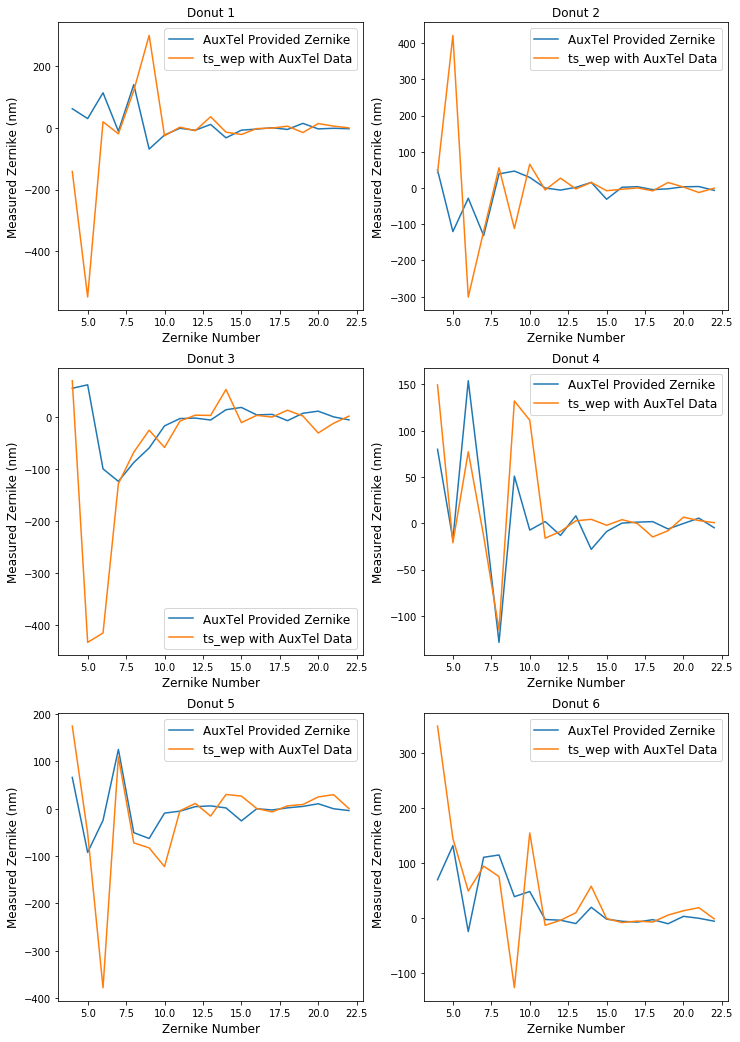

In [14]:
fig = plt.figure(figsize=(12, 18))
for i in range(len(zern_list)):
    fig.add_subplot(3, 2, i+1)
    plt.plot(data['zern_index'][i], data['measured_zerns'][i], label='AuxTel Provided Zernike')
    plt.plot(data['zern_index'][i], zern_list[i], label='ts_wep with AuxTel Data')
    plt.legend(fontsize=12)
    plt.title('Donut %i' % (i+1), size=12)
    plt.xlabel('Zernike Number', size=12)
    plt.ylabel('Measured Zernike (nm)', size=12)